

```
Target:
        1) Get the basic model ready
        2) try to get the max accuracy as much as possible.
        3) Try to stick to 15 epochs but can strech to 20 to see the behaviour.
Result:
        1) Best Training Accuracy: 99.91
        2) Best Test Accuracy: 99.32
        3) Params:6.9M
Analysis:
        1) Model is heavy as expected and overfitted.
        3) Can be squezed, so will do that first



In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
  #1x28x28
  def __init__(self):
    super(Net, self).__init__()
    self.convolution1 = nn.Sequential(
        nn.Conv2d(1, 16, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.convolution2 = nn.Sequential(
        nn.Conv2d(32, 64, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.convolution3 = nn.Sequential(
        nn.Conv2d(128, 256, 3), 
        nn.ReLU(),
        nn.Conv2d(256, 128, 3),
        nn.ReLU(),
        nn.Conv2d(128, 10, 3)
    )

  def forward(self, x):
    x = self.convolution1(x)
    x = self.convolution2(x)
    x = self.convolution3(x)
    x = x.view(-1, 10)
    return F.log_softmax(x)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           4,640
              ReLU-4           [-1, 32, 28, 28]               0
         MaxPool2d-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 64, 14, 14]          18,496
              ReLU-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
              ReLU-9          [-1, 128, 14, 14]               0
        MaxPool2d-10            [-1, 128, 7, 7]               0
           Conv2d-11            [-1, 256, 5, 5]         295,168
             ReLU-12            [-1, 256, 5, 5]               0
           Conv2d-13            [-1, 128, 3, 3]         295,040
             ReLU-14            [-1, 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:
torch.manual_seed(1)
batch_size=128
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
                datasets.MNIST("../data", train=True, download=True,
                               transform = transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.1307,), (0.3081,))
                               ])),
                batch_size=batch_size, shuffle=True, **kwargs
              )
test_loader = torch.utils.data.DataLoader(
              datasets.MNIST("../data", train=False, download=True,
                             transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.1307,),(0.3081,))
                             ])),
              batch_size=batch_size, shuffle=True, **kwargs
              )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [5]:
import os
print(os.listdir("sample_data"))

['README.md', 'anscombe.json', 'mnist_test.csv', 'california_housing_train.csv', 'california_housing_test.csv', 'mnist_train_small.csv']


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


Text(0.5, 1.0, '4')

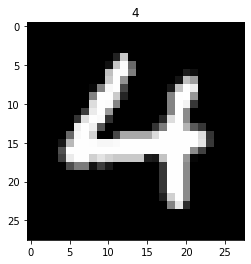

In [7]:
df_train = pd.read_csv('sample_data/mnist_train_small.csv')
import matplotlib.pyplot as plt
ind = np.random.randint(0, df_train.shape[0]-1)
plt.imshow(df_train.iloc[ind].values[1:].reshape((28,28)), cmap='gray')
plt.title(str(df_train.iloc[ind][0]))

In [8]:
from tqdm import tqdm
train_loss = []
train_acc = []
def train(model, device, train_loader, optimizer, epoch):
    model.train()

    correct=0
    processed=0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss.append(loss)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(0, 20):
  print (f"epoch : {epoch}")
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

epoch : 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.0756787434220314 batch_id=468 Accuracy=78.82333333333334: 100%|██████████| 469/469 [00:24<00:00, 18.94it/s]



Test set: Average loss: 0.0837, Accuracy: 9739/10000 (97%)

epoch : 1


loss=0.0703587681055069 batch_id=468 Accuracy=97.96666666666667: 100%|██████████| 469/469 [00:15<00:00, 30.37it/s]



Test set: Average loss: 0.0464, Accuracy: 9854/10000 (99%)

epoch : 2


loss=0.08081768453121185 batch_id=468 Accuracy=98.665: 100%|██████████| 469/469 [00:14<00:00, 32.52it/s]



Test set: Average loss: 0.0333, Accuracy: 9895/10000 (99%)

epoch : 3


loss=0.012092930264770985 batch_id=468 Accuracy=99.01666666666667: 100%|██████████| 469/469 [00:15<00:00, 31.26it/s]



Test set: Average loss: 0.0287, Accuracy: 9904/10000 (99%)

epoch : 4


loss=0.053979117423295975 batch_id=468 Accuracy=99.17333333333333: 100%|██████████| 469/469 [00:15<00:00, 30.72it/s]



Test set: Average loss: 0.0300, Accuracy: 9889/10000 (99%)

epoch : 5


loss=0.004698066506534815 batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:15<00:00, 30.77it/s]



Test set: Average loss: 0.0279, Accuracy: 9905/10000 (99%)

epoch : 6


loss=0.026194676756858826 batch_id=468 Accuracy=99.48166666666667: 100%|██████████| 469/469 [00:16<00:00, 28.97it/s]



Test set: Average loss: 0.0228, Accuracy: 9922/10000 (99%)

epoch : 7


loss=0.00690421974286437 batch_id=468 Accuracy=99.63333333333334: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]



Test set: Average loss: 0.0255, Accuracy: 9927/10000 (99%)

epoch : 8


loss=0.002657312201336026 batch_id=468 Accuracy=99.63333333333334: 100%|██████████| 469/469 [00:14<00:00, 31.34it/s]



Test set: Average loss: 0.0290, Accuracy: 9908/10000 (99%)

epoch : 9


loss=0.0016058228211477399 batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:15<00:00, 30.78it/s]



Test set: Average loss: 0.0273, Accuracy: 9915/10000 (99%)

epoch : 10


loss=0.008975030854344368 batch_id=468 Accuracy=99.77833333333334: 100%|██████████| 469/469 [00:14<00:00, 31.52it/s]



Test set: Average loss: 0.0383, Accuracy: 9894/10000 (99%)

epoch : 11


loss=0.00037528888788074255 batch_id=468 Accuracy=99.80666666666667: 100%|██████████| 469/469 [00:15<00:00, 30.67it/s]



Test set: Average loss: 0.0442, Accuracy: 9888/10000 (99%)

epoch : 12


loss=0.0002516508393455297 batch_id=468 Accuracy=99.83333333333333: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]



Test set: Average loss: 0.0297, Accuracy: 9923/10000 (99%)

epoch : 13


loss=0.0010932659497484565 batch_id=468 Accuracy=99.86833333333334: 100%|██████████| 469/469 [00:14<00:00, 31.47it/s]



Test set: Average loss: 0.0264, Accuracy: 9932/10000 (99%)

epoch : 14


loss=0.005616719368845224 batch_id=468 Accuracy=99.91: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]



Test set: Average loss: 0.0328, Accuracy: 9916/10000 (99%)

epoch : 15


loss=0.013228454627096653 batch_id=468 Accuracy=99.92666666666666: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]



Test set: Average loss: 0.0299, Accuracy: 9917/10000 (99%)

epoch : 16


loss=0.02173720858991146 batch_id=468 Accuracy=99.93666666666667: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]



Test set: Average loss: 0.0324, Accuracy: 9922/10000 (99%)

epoch : 17


loss=0.001031903550028801 batch_id=468 Accuracy=99.945: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]



Test set: Average loss: 0.0279, Accuracy: 9931/10000 (99%)

epoch : 18


loss=0.00011683400953188539 batch_id=468 Accuracy=99.975: 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]



Test set: Average loss: 0.0298, Accuracy: 9933/10000 (99%)

epoch : 19


loss=0.0008810207364149392 batch_id=468 Accuracy=99.96666666666667: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]



Test set: Average loss: 0.0367, Accuracy: 9921/10000 (99%)

